# Volkswagen golf data analysis

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import re

In [2]:
# Load the Data
dataset_df = pd.read_csv('../car-golf-dataset.csv', sep=';')
info_df = pd.read_csv('../car-golf-info.csv', sep=';')


In [3]:
info_df.head(1)

,id,make,model,submodel,modification_key,modification,fuel,door_count,capacity,power1,...,construction_start,construction_end,meta,final_submodel,parsed_model,parsed_engine_type,parsed_engine_size,parsed_options,parsed_category,parsed_transmission
0,28,VW,GOLF (2008 - 2012) VI,VW GOLF (2008 - 2012) VI Cabrio,20552357-aff2-5384-afab-4619c87aa3c2,Golf 2.0 TDI,D,2,1968,103,...,2008,2013,"{""raw"":""Golf 2.0 TDI\nD\n2\n1968\n 103 (140)\n...",NaN,Golf,TDI,2.0,NaN,Cabriolet/Roadster,manual


In [4]:
info_df.head(1)

,id,make,model,submodel,modification_key,modification,fuel,door_count,capacity,power1,...,construction_start,construction_end,meta,final_submodel,parsed_model,parsed_engine_type,parsed_engine_size,parsed_options,parsed_category,parsed_transmission
0,28,VW,GOLF (2008 - 2012) VI,VW GOLF (2008 - 2012) VI Cabrio,20552357-aff2-5384-afab-4619c87aa3c2,Golf 2.0 TDI,D,2,1968,103,...,2008,2013,"{""raw"":""Golf 2.0 TDI\nD\n2\n1968\n 103 (140)\n...",NaN,Golf,TDI,2.0,NaN,Cabriolet/Roadster,manual


# Prepare the data
## 1. Come up with logic/algorithm to assign correct engine_type and category to car rows:
* 1.1 engine_type is nicely defined in car-golf-info file (modification column. there’s also parsed_engine_type which should be accurate but needs double-checking to make sure) while car-golf-dataset file has title field that need to be processed to properly get accurate engine_type. i.e. title: Volkswagen Golf 1.5 TSI Comfortline R-Line Navi - engine_type is “TSI”, not “R”

## First double-check the engine type extraction in the car-golf-info file


In [5]:
# Check the engine type distribution    
info_df['parsed_engine_type'].value_counts()

TSI                       228
TDI                       127
eTSI                       23
TDI-CR                      9
GTI                         7
R                           3
TSI eHybrid                 3
GTD                         2
e-Golf                      2
TSI Plug-In-Hybrid GTE      1
TSI GTE                     1
Name: parsed_engine_type, dtype: int64

In [6]:
def extract_engine_type_from_modification(modification):
    # Convert modification to lowercase first
    modification = str(modification).lower()
    
    # Define standardized engine types (in the format we want to return)
    engine_type_mapping = {
        'tsi ehybrid': 'TSI eHybrid',
        'tsi plug-in-hybrid gte': 'TSI Plug-In-Hybrid GTE',
        'tsi gte': 'TSI GTE',
        'tdi-cr': 'TDI-CR',
        'e-golf': 'e-Golf',
        'tsi': 'TSI',
        'tdi': 'TDI',
        'gtd': 'GTD',
        'etsi': 'eTSI',
        'gti': 'GTI',
        'r': 'R'
    }
    
    # First, try to find patterns where engine type is attached to numbers (e.g., 1.6TDI, 1.0TSI)
    numeric_pattern = r'\d+\.?\d*([a-zA-Z]+)'
    numeric_matches = re.findall(numeric_pattern, modification)
    
    if numeric_matches:
        # Check if any of the matches correspond to our engine types
        for match in numeric_matches:
            match = match.lower()
            if match in engine_type_mapping:
                return engine_type_mapping[match]
    
    # If no matches found with numbers, try the original pattern
    pattern = r'\b(' + '|'.join(engine_type_mapping.keys()) + r')\b'
    matches = re.findall(pattern, modification)
    
    # If there are matches, return the standardized format of the first match
    if matches:
        return engine_type_mapping[matches[0]]
    
    return np.nan  # Return nan if no matches found


In [7]:
# Apply the extraction function to create a new column
info_df['extracted_engine_type'] = info_df['modification'].apply(extract_engine_type_from_modification)


In [8]:
# Check the engine type extraction
info_df[['modification','parsed_engine_type','extracted_engine_type']].head(5)

,modification,parsed_engine_type,extracted_engine_type
0,Golf 2.0 TDI,TDI,TDI
1,Golf 1.6 TDI DPF Trendline M5,TDI,TDI
2,Golf 1.6 TDI DPF Trendline M5,TDI,TDI
3,Golf 1.6 TDI DPF BlueMotion M5,TDI,TDI
4,Golf 1.6 TDI DPF Comfortline M5,TDI,TDI


In [9]:
# Check the engine type distribution
info_df['parsed_engine_type'].value_counts()

TSI                       228
TDI                       127
eTSI                       23
TDI-CR                      9
GTI                         7
R                           3
TSI eHybrid                 3
GTD                         2
e-Golf                      2
TSI Plug-In-Hybrid GTE      1
TSI GTE                     1
Name: parsed_engine_type, dtype: int64

In [10]:
# Check the extracted engine type distribution
info_df['extracted_engine_type'].value_counts()

TSI                       228
TDI                       127
eTSI                       23
TDI-CR                      9
GTI                         7
R                           3
TSI eHybrid                 3
GTD                         2
e-Golf                      2
TSI Plug-In-Hybrid GTE      1
TSI GTE                     1
Name: extracted_engine_type, dtype: int64

In [11]:
# Check if the extracted engine type is the same as the parsed engine type
print(f'Extracted engine type is the same as the parsed engine type: {info_df["parsed_engine_type"].equals(info_df["extracted_engine_type"])}')

Extracted engine type is the same as the parsed engine type: True


## Apply the extracted engine type to the dataset 

In [12]:
dataset_df.head(1)

,source_id,title,category,make,model,power,color,capacity,transmission,fuel,construction_year,price_net,price_gross,added,mileage,url
0,286354023,"Volkswagen Golf -Black Weeks-Fahrzeug, täglich...",Estate Car,volkswagen,golf,123,NaN,1395,Manual gearbox,Petrol,2015-01-01 00:00:00.000000,10466.0,12140,2020-11-26 01:11:25.000000,76973,https://suchen.mobile.de/fahrzeuge/details.htm...


In [13]:
# Apply the function to the dataset
dataset_df['extracted_engine_type'] = dataset_df['title'].apply(extract_engine_type_from_modification)

dataset_df[['title','extracted_engine_type']].head()


,title,extracted_engine_type
0,"Volkswagen Golf -Black Weeks-Fahrzeug, täglich...",NaN
1,Volkswagen Golf Var. VII 2.0 TDI DSG GTD Sport...,TDI
2,Volkswagen Golf VII Sportsvan Van/Lounge 2.0 T...,TDI
3,Volkswagen Golf Sportsvan 1.2 TSI Lounge AAC ...,TSI
4,Volkswagen Golf 7 Sportsvan Allstar 1.6 TDI BM...,TDI


In [14]:
# Check the null values
dataset_df.isnull().sum()

source_id                    0
title                        0
category                     0
make                       115
model                        0
power                        0
color                     7235
capacity                     0
transmission                49
fuel                       487
construction_year            0
price_net                30300
price_gross                  0
added                        0
mileage                      0
url                          0
extracted_engine_type    15304
dtype: int64

In [15]:
# Check the shape of the dataset    
dataset_df.shape

(77744, 17)

In [16]:
# Check the extracted engine type distribution
dataset_df['extracted_engine_type'].value_counts()

TSI            22286
TDI            18939
eTSI            7086
GTI             6333
R               4823
GTD             2076
e-Golf           701
TSI eHybrid      139
TSI GTE           57
Name: extracted_engine_type, dtype: int64

# 1.2 category value in car-golf-dataset have quite bad accuracy so need to use car-golf-info (submodel column has this info. also extracted to parsed_category) to improve category field

In [17]:
# Group by submodel and parsed_category and count the size of each group
grouped_df = info_df.groupby(['submodel', 'parsed_category']).size().reset_index(name='size')
# Sort the grouped data by parsed_category in descending order
sorted_df = grouped_df.sort_values(by='parsed_category', ascending=False)   
sorted_df

,submodel,parsed_category,size
8,VW GOLF PLUS (2008 - 2013) VI Vienatūris,Van/Minibus,28
1,VW GOLF (2008 - 2012) VI Hečbekas,Small Car,61
3,VW GOLF (2012 - 2020) VII Hečbekas,Small Car,122
5,VW GOLF (2019 - ) VIII Hečbekas,Small Car,43
2,VW GOLF (2008 - 2012) VI Universalas,Estate Car,31
4,VW GOLF (2012 - 2020) VII Universalas,Estate Car,59
6,VW GOLF (2019 - ) VIII Universalas,Estate Car,34
7,VW GOLF ALLTRACK (2014 - 2020) Universalas,Estate Car,5
9,VW GOLF SPORTSVAN (2014 - 2020) Universalas,Estate Car,36
0,VW GOLF (2008 - 2012) VI Cabrio,Cabriolet/Roadster,1


* I have seen that there is no name exists(e.g. Vienatūris, Hečbekas, Universalas) in the title field in the car-golf-dataset file. Though Cabrio exists but i didn't consider it as a reason of selecting the category. I have taken PLUS, SPORTVAN, ALLTRACK as a reason of selecting the category and these are existing in the title field.

In [18]:
# Create a mapping dictionary based on the patterns we found
category_mapping = {
    'plus': 'Van/Minibus',
    'sportsvan': 'Estate Car',
    'alltrack': 'Estate Car'
}

# Create a duplicate of the category column for comparison
dataset_df['original_category'] = dataset_df['category']

# Function to improve category based on title
def improve_category(row):
    title = row['title'].lower()
    
    # Check if any of our mapping keys exist in the title
    for key, category in category_mapping.items():
        if key in title:
            return category
    
    # If no mapping found, return original category
    return row['category']

# Apply the improvement function
dataset_df['category'] = dataset_df.apply(improve_category, axis=1)

dataset_df[['title', 'original_category', 'category']].head()

,title,original_category,category
0,"Volkswagen Golf -Black Weeks-Fahrzeug, täglich...",Estate Car,Estate Car
1,Volkswagen Golf Var. VII 2.0 TDI DSG GTD Sport...,Estate Car,Estate Car
2,Volkswagen Golf VII Sportsvan Van/Lounge 2.0 T...,Saloon,Estate Car
3,Volkswagen Golf Sportsvan 1.2 TSI Lounge AAC ...,Van / Minibus,Estate Car
4,Volkswagen Golf 7 Sportsvan Allstar 1.6 TDI BM...,Saloon,Estate Car


In [19]:
# See the columns
dataset_df.columns

Index(['source_id', 'title', 'category', 'make', 'model', 'power', 'color',
       'capacity', 'transmission', 'fuel', 'construction_year', 'price_net',
       'price_gross', 'added', 'mileage', 'url', 'extracted_engine_type',
       'original_category'],
      dtype='object')

In [20]:
# Drop original_category column
dataset_df.drop(columns=['original_category'],inplace=True)


In [21]:
dataset_df.columns

Index(['source_id', 'title', 'category', 'make', 'model', 'power', 'color',
       'capacity', 'transmission', 'fuel', 'construction_year', 'price_net',
       'price_gross', 'added', 'mileage', 'url', 'extracted_engine_type'],
      dtype='object')

In [22]:
dataset_df['power'].isnull().sum()

0

# Clean the data
## 2. Detect suspicious car rows. few examples:
* title: Volkswagen Golf 2.0 TDI DSG Klimatronic,Leder,Navi,1 Hand; transmission: Manual gearbox - DSG vs manual gearbox is contradicting so suspicious
* title: Volkswagen Golf VIII Lim. Style eHybrid DSG~LED~ACC~KAMERA~; fuel: Petrol - hybrid but fuel simply says petrol
* there’s no explicit power value but title has power
power doesn’t match any possible variation so probably data was entered wrongly

## Suspicious Record Detection


### 1. Transmission Mismatch
#### Conditions Checked:
- Title mentions "DSG" but transmission is listed as "Manual gearbox"
- Title mentions "Manual" but transmission is listed as "Automatic transmission"
#### Why Suspicious:
- DSG (Direct-Shift Gearbox) is a type of automatic transmission
- Direct contradictions between title and transmission field indicate data entry errors

### 2. Fuel Type Mismatch
#### Conditions Checked:
- Electric/Hybrid models (eHybrid, GTE, e-Golf) listed with pure Petrol or Diesel fuel
- TDI (diesel) engine listed with Petrol fuel
- TSI (petrol) engine listed with Diesel fuel
#### Why Suspicious:
- Electric/Hybrid vehicles require specific fuel type entries
- TDI engines can only use Diesel fuel
- TSI engines can only use Petrol fuel

### 3. Price Inconsistency
#### Condition Checked:
- Gross price is less than net price
#### Why Suspicious:
- Gross price (including tax) should always be higher than net price (excluding tax)
- Reversed values indicate data entry errors

### Usage
The function returns a DataFrame with boolean columns for each type of suspicious condition:
- transmission_mismatch
- fuel_mismatch
- power_issue
- price_mismatch

Each row indicates whether that listing has any of these suspicious conditions.

In [23]:
dataset_df['transmission'].value_counts()

Automatic                 40671
Manual gearbox            34055
Automatic transmission     2284
automatic                   481
Semi-automatic              204
Name: transmission, dtype: int64

In [24]:
dataset_df['fuel'].value_counts()

Petrol                                                    40875
Diesel                                                    26406
Petrol, E10-enabled                                        6102
Hybrid (petrol/electric)                                   1561
Hybrid (petrol/electric), Plug-in hybrid                    840
Natural Gas                                                 551
Electric                                                    298
Other                                                       257
Hybrid (petrol/electric), E10-enabled, Plug-in hybrid       133
Hybrid (petrol/electric), E10-enabled                        86
Diesel, Biodiesel Suitable                                   66
LPG                                                          49
Diesel, E10-enabled                                          14
Diesel, Suitable for Vegetable Oil                            5
Diesel, Biodiesel Suitable, Suitable for Vegetable Oil        4
Natural Gas, E10-enabled                

In [25]:
dataset_df['power'].value_counts()

148    22603
114     9395
109     7774
129     7610
241     4795
       ...  
14         1
209        1
405        1
185        1
404        1
Name: power, Length: 144, dtype: int64

In [26]:

def find_suspicious_records(df):
    suspicious = pd.DataFrame()
    
    # Create list of automatic transmissions for better matching
    automatic_variants = ['Automatic', 'Automatic transmission', 'automatic']
    
    # Transmission inconsistency
    suspicious['transmission_mismatch'] = (
        # DSG (automatic) marked as manual
        (df['title'].str.contains('DSG', case=False) & (df['transmission'] == 'Manual gearbox')) |
        # Manual in title but marked as any type of automatic
        (df['title'].str.contains('Manual', case=False) & df['transmission'].isin(automatic_variants))
    )
    
    # Create lists for fuel type matching
    petrol_variants = [
        'Petrol',
        'Petrol, E10-enabled',
        'Petrol, Biodiesel Suitable'
    ]
    
    diesel_variants = [
        'Diesel',
        'Diesel, E10-enabled',
        'Diesel, Biodiesel Suitable',
        'Diesel, Suitable for Vegetable Oil',
        'Diesel, Biodiesel Suitable, Suitable for Vegetable Oil'
    ]
    
    hybrid_variants = [
        'Hybrid (petrol/electric)',
        'Hybrid (petrol/electric), Plug-in hybrid',
        'Hybrid (petrol/electric), E10-enabled',
        'Hybrid (petrol/electric), E10-enabled, Plug-in hybrid',
        'Hybrid (diesel/electric)'
    ]
    
    # Fuel type inconsistency
    suspicious['fuel_mismatch'] = (
        # Hybrid/Electric models with only conventional fuel
        ((df['title'].str.contains('eHybrid|GTE|e-Golf', case=False)) & 
         (~df['fuel'].isin(hybrid_variants + ['Electric']))) |
        # TDI (diesel) engine with any petrol fuel
        ((df['extracted_engine_type'] == 'TDI') & 
         (df['fuel'].isin(petrol_variants))) |
        # TSI (petrol) engine with any diesel fuel
        ((df['extracted_engine_type'] == 'TSI') & 
         (df['fuel'].isin(diesel_variants)))
    )
    
    # # Power inconsistency
    # def extract_power_from_title(title):
    #     power_match = re.search(r'(\d+)\s*PS', str(title))
    #     return int(power_match.group(1)) if power_match else None
    
    # # Add power from title column
    # df['power_from_title'] = df['title'].apply(extract_power_from_title)
    
    # # Check both missing power and power mismatch
    # suspicious['power_issue'] = (
    #     # Missing power but mentioned in title
    #     (df['power'].isna() & df['power_from_title'].notna()) |
    #     # Power mismatch (allowing for small variations due to conversion)
    #     ((df['power_from_title'].notna()) & (df['power'].notna()) & 
    #      (abs(df['power_from_title'] - df['power']) > 4))
    # )
    
    # Price inconsistency - only when net price is higher than gross price
    suspicious['price_mismatch'] = (df['price_gross'] < df['price_net'])
    
    return suspicious

# Apply the function
suspicious_records = find_suspicious_records(dataset_df)

# Show summary of suspicious records
print("Summary of suspicious records:")
for column in suspicious_records.columns:
    count = suspicious_records[column].sum()
    print(f"{column}: {count} suspicious records")


Summary of suspicious records:
transmission_mismatch: 134 suspicious records
fuel_mismatch: 539 suspicious records
price_mismatch: 0 suspicious records


### Remove the suspicious records

In [27]:
# Create a mask for all suspicious records
suspicious_mask = suspicious_records.any(axis=1)

# Get the count of total suspicious records
total_suspicious = suspicious_mask.sum()

# Create clean dataset by dropping all suspicious records
clean_dataset = dataset_df[~suspicious_mask].copy()

# Print summary
print(f"Original dataset size: {len(dataset_df)}")
print(f"Number of suspicious records removed: {total_suspicious}")
print(f"Clean dataset size: {len(clean_dataset)}")



Original dataset size: 77744
Number of suspicious records removed: 672
Clean dataset size: 77072


In [28]:
# Verify that suspicious records were removed
verification = find_suspicious_records(clean_dataset)
print("\nVerification of clean dataset:")
for column in verification.columns:
    count = verification[column].sum()
    print(f"{column}: {count} suspicious records")


Verification of clean dataset:
transmission_mismatch: 0 suspicious records
fuel_mismatch: 0 suspicious records
price_mismatch: 0 suspicious records


# Cleaning the dataset


## Cleaning Function

This function performs the following cleaning operations:
1. Removes unnecessary columns
2. Handles missing values
3. Converts date columns to proper datetime format
4. Resets the index

### Columns Dropped:
- `source_id`: Unique identifier, not needed for analysis
- `title`: Already extracted necessary information (engine type)
- `make`: Constant value (all "Volkswagen")
- `model`: Constant value (all "Golf")
- `price_net`: High number of missing values
- `url`: Not needed for analysis
- `power_from_title`: Temporary column used for validation

### Missing Values:
- Drops all rows with missing values to ensure data quality
- Resets index after dropping rows

### Date Columns:
- `added`: Listing creation date
- `construction_year`: Car manufacturing date

In [29]:
def clean_dataset(df):
    """
    Clean the dataset by removing unnecessary columns, handling missing values,
    and ensuring proper data types.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame to be cleaned
        
    Returns:
    --------
    pandas.DataFrame
        Cleaned DataFrame with:
        - Unnecessary columns removed
        - No missing values
        - Proper date formats
        - Reset index
    """
    # Make a copy to avoid modifying original data
    df = df.copy()
    
    # 1. Drop unnecessary columns
    columns_to_drop = [
        'source_id',  # Unique identifier, not needed
        'title',      # Already extracted necessary info
        'make',       # All values are Volkswagen
        'model',      # All values are Golf
        'price_net',  # Many missing values
        'url',        # Not needed for analysis
    ]
    df.drop(columns=columns_to_drop, inplace=True)
    
    # 2. Drop rows with missing values
    df.dropna(inplace=True)
    
    # 3. Convert date columns to datetime
    date_columns = ['added', 'construction_year']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col])
    
    # 4. Reset index
    df.reset_index(drop=True, inplace=True)
    
    return df

# Apply the cleaning function
clean_dataset = clean_dataset(dataset_df)

# Display information about the cleaned dataset
print("Cleaned dataset shape:", clean_dataset.shape)


Cleaned dataset shape: (56333, 11)


In [30]:
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56333 entries, 0 to 56332
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   category               56333 non-null  object        
 1   power                  56333 non-null  int64         
 2   color                  56333 non-null  object        
 3   capacity               56333 non-null  int64         
 4   transmission           56333 non-null  object        
 5   fuel                   56333 non-null  object        
 6   construction_year      56333 non-null  datetime64[ns]
 7   price_gross            56333 non-null  int64         
 8   added                  56333 non-null  datetime64[ns]
 9   mileage                56333 non-null  int64         
 10  extracted_engine_type  56333 non-null  object        
dtypes: datetime64[ns](2), int64(4), object(5)
memory usage: 4.7+ MB


In [31]:
clean_dataset.isnull().sum()

category                 0
power                    0
color                    0
capacity                 0
transmission             0
fuel                     0
construction_year        0
price_gross              0
added                    0
mileage                  0
extracted_engine_type    0
dtype: int64

## Category Standardization



In [32]:
clean_dataset['category'].value_counts()

Saloon                                                  18674
Limousine                                               16769
Estate Car                                               7421
EstateCar                                                5601
Saloon, Employees Car                                    3464
Saloon, Demonstration Vehicle                             801
Van/Minibus                                               694
Saloon, Pre-Registration                                  551
Estate Car, Employees Car                                 431
Other                                                     311
Small Car                                                 279
Cabriolet / Roadster                                      278
Estate Car, Demonstration Vehicle                         182
Cabrio                                                    171
Estate Car, Pre-Registration                              170
SportsCar                                                 156
OtherCar

The dataset contains car categories that are semantically identical but have different spellings or spacing. This function standardizes these category names while preserving distinct categories.

### Current Issues:
- 'EstateCar' vs 'Estate Car'
- 'Van/Minibus' vs 'Van / Minibus'
- 'SmallCar' vs 'Small Car'
- 'SportsCar' vs 'Sports Car'
- 'OtherCar' vs 'Other'

### What the Function Does:
1. Creates a mapping dictionary for categories that need standardization
2. Applies the mapping to normalize spellings and spaces
3. Preserves distinct categories (e.g., 'Saloon, Employees Car' remains unchanged)



In [33]:
def standardize_categories(df):
    """
    Standardize category names by fixing only spelling and space variations.
    Keeps distinct categories (like 'Saloon, Employees Car') unchanged.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame with a 'category' column
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with standardized category names
    """
    # Make a copy to avoid modifying original data
    df = df.copy()
    
    # Create mapping only for exact same categories with different spellings/spaces
    category_mapping = {
        'EstateCar': 'Estate Car',
        'Van/Minibus': 'Van / Minibus',
        'SmallCar': 'Small Car',
        'SportsCar': 'Sports Car',
        'OtherCar': 'Other'
    }
    
    # Apply the mapping
    df['category'] = df['category'].replace(category_mapping)
    
    return df

# Apply the standardization
clean_dataset = standardize_categories(clean_dataset)

## Transmission Standardization

In [34]:
clean_dataset['transmission'].value_counts()

Automatic                 33243
Manual gearbox            22456
automatic                   406
Semi-automatic              175
Automatic transmission       53
Name: transmission, dtype: int64


The dataset contains transmission types that are semantically identical but have different capitalizations or wordings. This function standardizes these transmission values.

### Current Issues:
- 'Automatic' vs 'automatic' vs 'Automatic transmission' (same meaning, different format)
- Need to standardize to single format 'Automatic'

### Final Categories:
- Automatic
- Manual gearbox  
- Semi-automatic

In [35]:
def standardize_transmission(df):
    """
    Standardize transmission values by converting variations of 'Automatic'
    to a single standard format.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame with a 'transmission' column
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with standardized transmission values
    """
    # Make a copy to avoid modifying original data
    df = df.copy()
    
    # Create mapping for transmission values
    transmission_mapping = {
        'automatic': 'Automatic',
        'Automatic transmission': 'Automatic'
    }
    
    # Apply the mapping
    df['transmission'] = df['transmission'].replace(transmission_mapping)
    
    return df

# Apply the standardization
clean_dataset = standardize_transmission(clean_dataset)



In [36]:
clean_dataset['transmission'].value_counts()

Automatic         33702
Manual gearbox    22456
Semi-automatic      175
Name: transmission, dtype: int64

## Fuel Type Cleaning



In [37]:
clean_dataset['fuel'].value_counts()

Petrol                                                    30794
Diesel                                                    19351
Petrol, E10-enabled                                        4535
Hybrid (petrol/electric)                                    887
Hybrid (petrol/electric), Plug-in hybrid                    289
Electric                                                    222
Other                                                       128
Hybrid (petrol/electric), E10-enabled                        53
Diesel, Biodiesel Suitable                                   26
Hybrid (petrol/electric), E10-enabled, Plug-in hybrid        21
Diesel, E10-enabled                                           9
Diesel, Suitable for Vegetable Oil                            5
LPG                                                           5
Natural Gas                                                   3
Diesel, Biodiesel Suitable, Suitable for Vegetable Oil        2
Hybrid (diesel/electric)                

The dataset contains an invalid fuel type entry that needs to be removed:
- '1.92/l (annual average 2023)' is not a valid fuel type, appears to be a price 

### Action:
- Remove row(s) containing this invalid fuel type entry
- Keep all legitimate fuel types (Petrol, Diesel, Hybrid, Electric, etc.)

In [38]:


# Remove the invalid fuel type row also reset index
clean_dataset = clean_dataset[clean_dataset['fuel'] != '1.92/l (annual average 2023)'].reset_index(drop=True)

# Verify the removal
print("\nUpdated fuel type distribution:")
clean_dataset['fuel'].value_counts()


Updated fuel type distribution:


Petrol                                                    30794
Diesel                                                    19351
Petrol, E10-enabled                                        4535
Hybrid (petrol/electric)                                    887
Hybrid (petrol/electric), Plug-in hybrid                    289
Electric                                                    222
Other                                                       128
Hybrid (petrol/electric), E10-enabled                        53
Diesel, Biodiesel Suitable                                   26
Hybrid (petrol/electric), E10-enabled, Plug-in hybrid        21
Diesel, E10-enabled                                           9
Diesel, Suitable for Vegetable Oil                            5
LPG                                                           5
Natural Gas                                                   3
Diesel, Biodiesel Suitable, Suitable for Vegetable Oil        2
Hybrid (diesel/electric)                

## Engine Capacity Cleaning



In [39]:
clean_dataset['capacity'].value_counts()

1498     15349
1968     13805
1984     11510
1598      5105
999       4622
1395      2273
1197      1498
0         1100
1390       605
2000       111
1998        97
1600        36
1495        27
1500        27
1986        24
1798        19
1198        14
1490        10
1489         7
10           7
1400         7
1496         7
1995         7
1989         5
1000         4
1485         3
1497         3
1999         3
1596         3
1896         3
1468         3
1595         3
1499         3
3500         2
1990         2
1994         2
1996         2
20           2
998          2
1988         2
1479         2
1950         1
1969         1
1584         1
1964         1
110          1
2            1
1199         1
2967         1
1590         1
14998        1
1965         1
1791         1
1488         1
1465         1
1            1
1486         1
Name: capacity, dtype: int64

The dataset contains some incorrect engine capacity values that need to be removed. Volkswagen Golf models typically have engine capacities between 999cc (1.0L) and 2000cc (2.0L).

### Issues Found:
1. Values that are too small (0, 1, 2, 10, 20)
2. Values that are too large (2967, 3500, 14998)
3. Invalid values (110)

### Valid Capacity Range:
- Minimum: ~999cc (1.0L)
- Maximum: ~2000cc (2.0L)

### Action:
Remove rows where engine capacity is:
- Less than 900cc
- Greater than 2100cc
This ensures we keep only valid Golf engine capacities while allowing for some data variation around the standard sizes.

In [40]:
def clean_capacity(df):
    """
    Remove rows with invalid engine capacity values.
    Valid range for Golf models: 900cc - 2100cc
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame with 'capacity' column
        
    Returns:
    --------
    pandas.DataFrame
        Cleaned DataFrame with only valid capacity values
    """
    # Make a copy to avoid modifying original data
    df = df.copy()
    
    # Store original length
    original_len = len(df)
    
    # Remove invalid capacity values
    df = df[(df['capacity'] >= 900) & (df['capacity'] <= 2100)]
    
    # Reset index
    df.reset_index(drop=True, inplace=True)
    
    # Print summary
    removed = original_len - len(df)
    print(f"Removed {removed} rows with invalid capacity values")
    print(f"Remaining rows: {len(df)}")
    
    return df

# Apply the cleaning
clean_dataset = clean_capacity(clean_dataset)



Removed 1116 rows with invalid capacity values
Remaining rows: 55216


In [41]:
# Show updated capacity distribution
print("\nUpdated capacity distribution:")
clean_dataset['capacity'].value_counts()


Updated capacity distribution:


1498    15349
1968    13805
1984    11510
1598     5105
999      4622
1395     2273
1197     1498
1390      605
2000      111
1998       97
1600       36
1500       27
1495       27
1986       24
1798       19
1198       14
1490       10
1496        7
1995        7
1489        7
1400        7
1989        5
1000        4
1896        3
1499        3
1596        3
1468        3
1497        3
1485        3
1595        3
1999        3
1479        2
998         2
1996        2
1988        2
1990        2
1994        2
1465        1
1199        1
1590        1
1969        1
1950        1
1965        1
1488        1
1791        1
1584        1
1964        1
1486        1
Name: capacity, dtype: int64

In [42]:
clean_dataset.head()

,category,power,color,capacity,transmission,fuel,construction_year,price_gross,added,mileage,extracted_engine_type
0,"Saloon, Demonstration Vehicle",148,Black Metallic,1498,Automatic,Petrol,2020-01-01 00:00:00,28985,2023-03-13 09:28:41,31500,eTSI
1,"Estate Car, Employees Car",148,Black Metallic,1968,Automatic,Diesel,2023-02-01 02:00:00,40850,2023-08-07 10:36:26,9500,TDI
2,Saloon,188,White Metallic,1984,Automatic,Petrol,2022-10-01 03:00:00,34950,2023-09-18 18:59:32,8,TSI
3,Cabriolet / Roadster,158,Purple Metallic,1390,Manual gearbox,Petrol,2012-03-01 02:00:00,12300,2023-09-19 17:04:42,64480,TSI
4,Saloon,148,Silver Metallic,1498,Automatic,Petrol,2022-01-01 02:00:00,32887,2023-09-24 16:58:41,15234,eTSI


# Visualize and make sense of data
### 3. What key trends do you see in this database?
* Please communicate these in 2-4 charts with short (2-4 sentence) commentary


/var/folders/gt/vjk4pjkx7vj4rs7tvxf6bd8h0000gn/T/ipykernel_29991/3983773549.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<Figure size 1200x600 with 0 Axes>

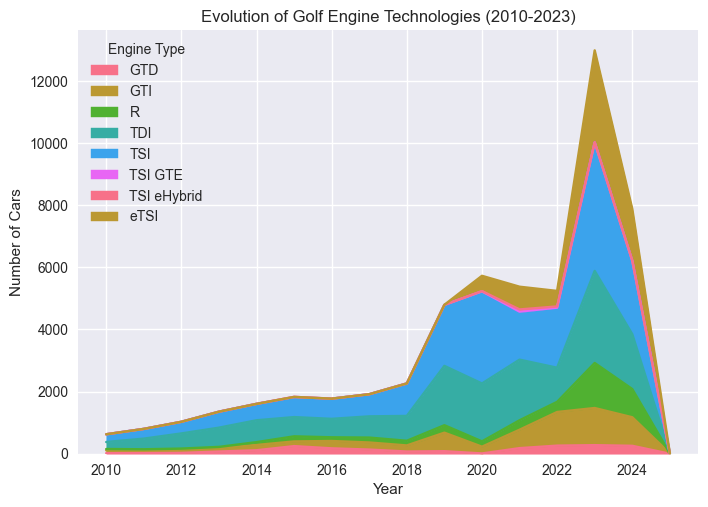

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualizations
plt.style.use('seaborn')
sns.set_palette("husl")

# Engine Technology Evolution
plt.figure(figsize=(12, 6))
engine_by_year = pd.crosstab(clean_dataset['construction_year'].dt.year, 
                            clean_dataset['extracted_engine_type'])
engine_by_year.plot(kind='area', stacked=True)
plt.title('Evolution of Golf Engine Technologies (2010-2023)')
plt.xlabel('Year')
plt.ylabel('Number of Cars')
plt.legend(title='Engine Type')
plt.grid(True)
plt.show()





### Engine Technology Trends:

- The graph reveals a significant transformation in Volkswagen Golf's engine lineup, with traditional diesel (TDI) engines dominating until 2015, followed by a sharp shift towards petrol (TSI) engines after the diesel emissions scandal. The most notable change occurs post-2019, where we see a dramatic increase in hybrid options (eTSI, TSI eHybrid) and performance variants (GTI, R), reflecting both environmental regulations and changing consumer preferences. This evolution demonstrates Volkswagen's strategic adaptation from conventional engines to more sustainable and diverse powertrain options, with hybrid technologies becoming increasingly prominent in recent years.




### What This Graph Shows (In more detail):
This graph shows how many Volkswagen Golfs were sold with different types of engines over the years. The height of each colored section shows the number of cars sold with that engine type.

### Key Trends:

1. **2010-2015: The Early Years**
   - Small number of cars sold
   - Mainly diesel (TDI) and regular petrol (TSI) engines
   - Very simple choices for buyers

2. **2015-2018: The Change**
   - Sales started growing
   - Diesel engines became less popular
   - More petrol engines were sold
   - New engine options started appearing

3. **2019-2022: The Big Shift**
   - Much higher sales numbers
   - Many new engine choices available
   - Hybrid engines (eTSI) became popular
   - Sport versions (GTI, R) increased
   - Shows Volkswagen's move toward more modern, cleaner engines

4. **2023-2024**
   - Peak in sales during 2023
   - Many different engine options available
   - Strong presence of hybrid and efficient engines
   - Drop in 2024 (because data is incomplete for this year)



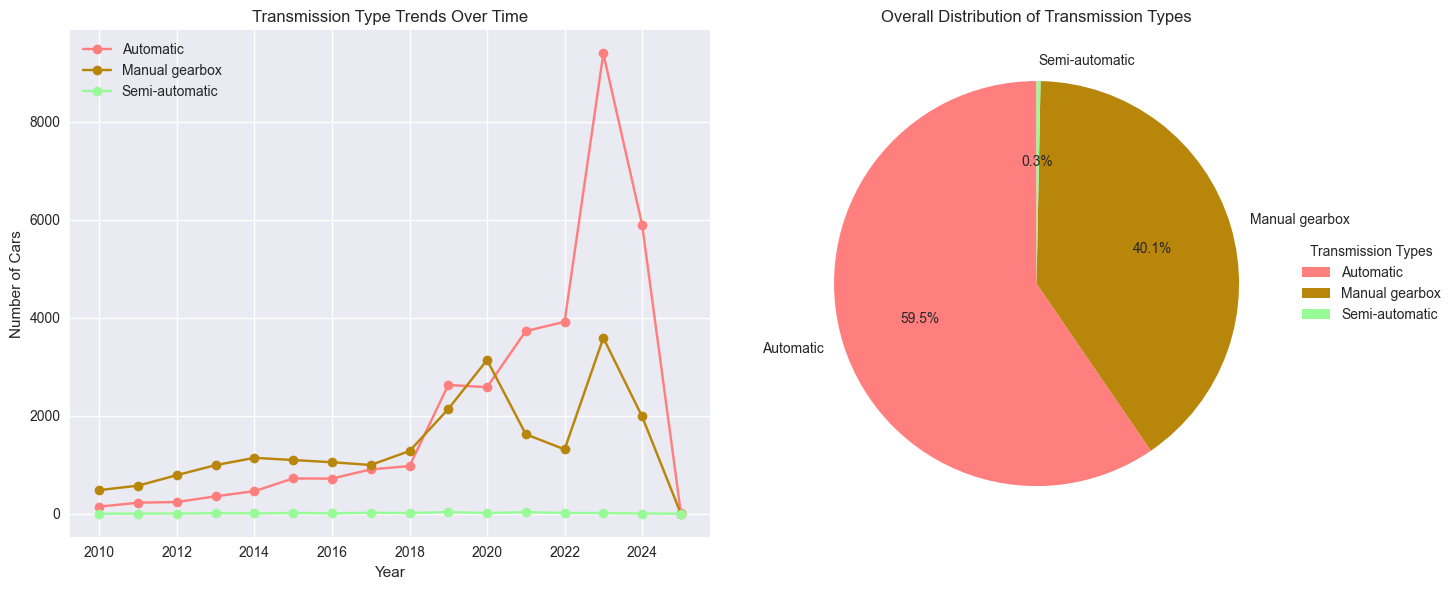


Transmission Trends in Volkswagen Golf (2010-2023):
The data shows a dramatic shift towards automatic transmissions, now representing 59.5% of all sales, 
while manual transmissions maintain a significant 40.2% market share despite their decline. 
Semi-automatic options remain a niche choice at just 0.3% of total sales.


In [44]:
# Define consistent colors for both plots
colors = {
    'Automatic': '#FF7F7F',       # Pink/Red (same as original line plot)
    'Manual gearbox': '#B8860B',  # Brown/Gold (same as original line plot)
    'Semi-automatic': '#98FB98'   # Green (same as original line plot)
}

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Line plot for trends over time
transmission_by_year = pd.crosstab(clean_dataset['construction_year'].dt.year, 
                                  clean_dataset['transmission'])
for column in transmission_by_year.columns:
    transmission_by_year[column].plot(kind='line', marker='o', 
                                    color=colors[column], 
                                    ax=ax1, 
                                    label=column)

ax1.set_title('Transmission Type Trends Over Time')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Cars')
ax1.grid(True)
ax1.legend()

# Pie chart for overall distribution
transmission_dist = clean_dataset['transmission'].value_counts()
ax2.pie(transmission_dist, 
        labels=transmission_dist.index, 
        autopct='%1.1f%%',
        colors=[colors[idx] for idx in transmission_dist.index], 
        startangle=90)
ax2.set_title('Overall Distribution of Transmission Types')

# Add legend to pie chart
ax2.legend(transmission_dist.index, 
          title="Transmission Types",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

print("""
Transmission Trends in Volkswagen Golf (2010-2023):
The data shows a dramatic shift towards automatic transmissions, now representing 59.5% of all sales, 
while manual transmissions maintain a significant 40.2% market share despite their decline. 
Semi-automatic options remain a niche choice at just 0.3% of total sales.""")

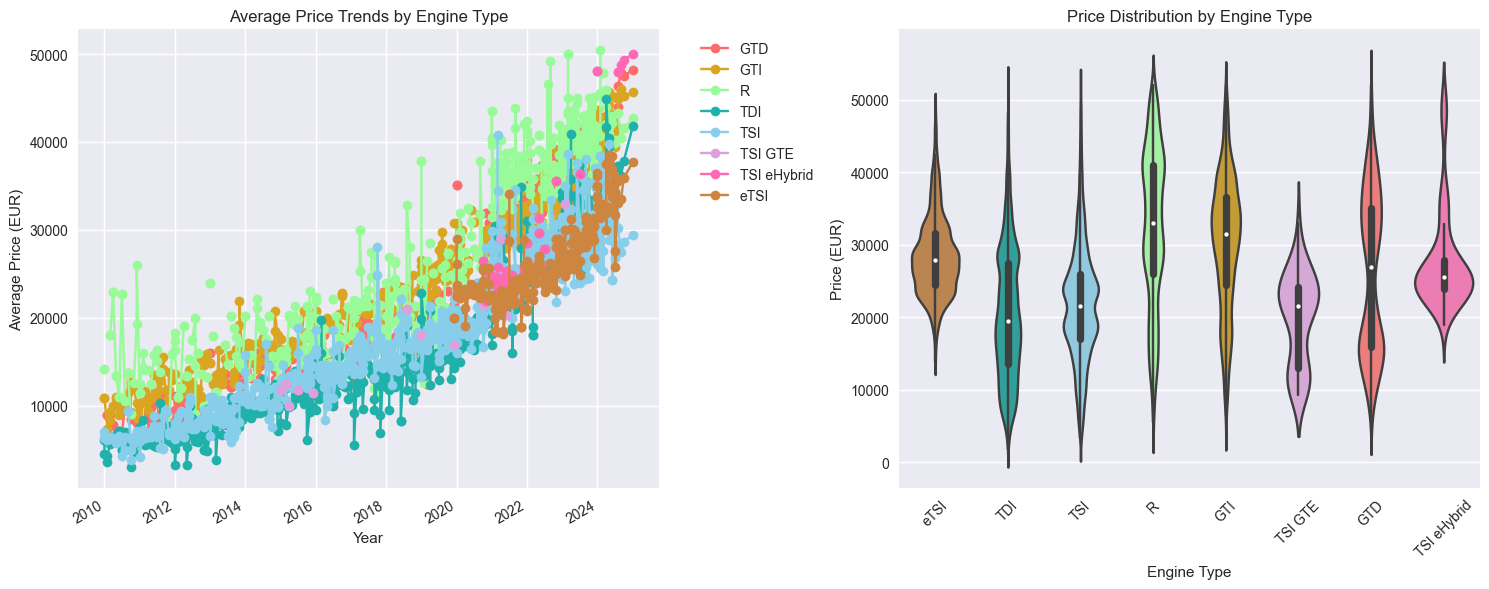

In [45]:
# Remove extreme outliers (prices above 99th percentile)
price_threshold = clean_dataset['price_gross'].quantile(0.99)
clean_dataset_filtered = clean_dataset[clean_dataset['price_gross'] <= price_threshold]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Define colors for all engine types
colors = {
    'TDI': '#20B2AA', 
    'TSI': '#87CEEB', 
    'GTI': '#DAA520',
    'GTD': '#FF6B6B',
    'R': '#98FB98', 
    'eTSI': '#CD853F', 
    'TSI eHybrid': '#FF69B4',
    'TSI GTE': '#DDA0DD'
}

# Create a color palette list in the same order as unique engine types
unique_engines = clean_dataset_filtered['extracted_engine_type'].unique()
color_palette = [colors[engine] for engine in unique_engines]

# Average price by year of construction and engine type
yearly_avg = clean_dataset_filtered.pivot_table(
    values='price_gross',
    index='construction_year',
    columns='extracted_engine_type',
    aggfunc='mean'
).rolling(window=2, min_periods=1).mean()

for engine in yearly_avg.columns:
    if engine in colors:
        yearly_avg[engine].plot(marker='o', 
                              color=colors[engine], 
                              label=engine, 
                              ax=ax1)

ax1.set_title('Average Price Trends by Engine Type')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Price (EUR)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True)

# Distribution of prices by engine type (violin plot)
sns.violinplot(data=clean_dataset_filtered, 
               x='extracted_engine_type', 
               y='price_gross',
               palette=color_palette,  # Use the same color palette
               ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.set_title('Price Distribution by Engine Type')
ax2.set_xlabel('Engine Type')
ax2.set_ylabel('Price (EUR)')

plt.tight_layout()
plt.show()




### Volkswagen Golf Price Analysis (2010-2023):

- The data reveals a clear price hierarchy among Golf variants, with performance models (R, GTI) and hybrid versions commanding premium prices, while traditional TDI and TSI engines maintain more moderate price points. The price gap between conventional and electrified variants has widened in recent years, reflecting both technological advancement and market positioning.



